# D22124454 - Deep Learning Assignment - Part 1
# News article section prediction task:

#### System specifics:
OS: Windows 11

RAM: 32 GB

GPU: RTX 3070

IDE: Models initially trained and evaluated on local - Jupyter IDE

#### Task overview:
This task is about creating models to predict the "section name" of the news articles in the dataset. There is a heavy focus on the use of RNNs and LSTMs.

#### Note:
#### In this notebook, we have the training and validation comparisons, along with a graph for evaluation comparison. The best performing models will be evaluated in the demo notebooks. The training was done in local with 20 epochs, so it might not give similar results with less epochs in collab. This might affect model performance.

#FAQ:
- If some of the plotly graphs are not rendering, run the code above the imports. For local running, it is "iframe". For colab running, it is "colab".
- Please enable GPU before running

### Imports:

In [ ]:
#IF PLOTLY GRAPHS DO NOT RENDER. SET TO COLAB WHEN RUN IN COLAB AND IFRAME FOR LOCAL (iframe)
#import plotly.io as pio
#pio.renderers.default = 'colab'

In [23]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np

In [24]:
import tensorflow_hub as hub

import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN, MaxPooling1D, Conv1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.datasets import imdb
import tensorflow as tf

import plotly.express as px
import matplotlib.pyplot as plt

In [25]:
from sklearn.preprocessing import OneHotEncoder
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [26]:
from keras.preprocessing.text import Tokenizer

In [27]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [28]:
# credentials to get the data file
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Reading the data from the csv file

In [29]:
guardCsv = drive.CreateFile({'id':'1BcNM4NZm_u-fY6jH3IEnxM87a6rTE_3R'})
guardCsv.GetContentFile('guardian_articles.csv')

In [30]:
raw_data = pd.read_csv("guardian_articles.csv", delimiter =",", index_col=False, )
display(raw_data)

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,us-news/2016/jan/31/iowa-caucus-underdog-candi...,US news,Iowa underdogs put on brave faces despite all ...,https://www.theguardian.com/us-news/2016/jan/3...,As polling day looms and the cameras turn only...,2016-01-31T23:53:37Z,1
1,us-news/2016/jan/31/iowa-caucus-worlds-most-pa...,US news,Iowa caucus: hologram eagle and Jesus star on ...,https://www.theguardian.com/us-news/2016/jan/3...,"In Des Moines on Sunday, the Guardian was give...",2016-01-31T23:46:28Z,2
2,world/2016/jan/31/tanzania-britsh-helicopter-p...,World news,British pilot in Tanzania 'manoeuvred ​to save...,https://www.theguardian.com/world/2016/jan/31/...,A British pilot who was shot dead by an elepha...,2016-01-31T23:43:48Z,3
3,football/2016/jan/31/late-winner-gets-usa-off-...,Football,USA 3-2 Iceland | International friendly match...,https://www.theguardian.com/football/2016/jan/...,USA took a step toward shaking off the ghosts ...,2016-01-31T23:30:49Z,4
4,football/2016/jan/31/blackburn-paul-lambert-ox...,Football,Reinvigorated Paul Lambert reflects after impr...,https://www.theguardian.com/football/2016/jan/...,"The clean-shaven, spectacle free and suspiciou...",2016-01-31T22:30:10Z,5
...,...,...,...,...,...,...,...
149834,world/2022/jun/21/marble-head-of-hercules-pull...,World news,Marble head of Hercules pulled up from Roman s...,https://www.theguardian.com/world/2022/jun/21/...,"For archaeologists, it’s the underwater find t...",2022-06-21T17:31:32Z,149835
149835,music/2022/jun/22/i-got-sick-of-talking-about-...,Music,‘I got sick of talking about myself’: Spacey J...,https://www.theguardian.com/music/2022/jun/22/...,"From under a mop of curls, Caleb Harper – Spac...",2022-06-21T17:30:09Z,149836
149836,australia-news/2022/jun/22/the-small-town-with...,Australia news,The small town with a big potato that inspired...,https://www.theguardian.com/australia-news/202...,"Robertson is a small, pretty town perched on t...",2022-06-21T17:30:09Z,149837
149837,australia-news/2022/jun/22/power-to-ban-citize...,Australia news,Power to ban citizens from re-entering Austral...,https://www.theguardian.com/australia-news/202...,A high court decision striking down the home a...,2022-06-21T17:30:08Z,149838


### Studying the topic distribution

For this project, we will be picking only the top 20 sections from the dataset. This is due to the following reasons:
1) If a record belongs to a section which has only 1 record belonging to that section, there is a good chance that there was a typo in the section name or some other issues
2) If there are less number of records belonging to the section, the model might not be able to learn the details anyway.
#### 3) If we know the number of sections we are taking, we can consistently set the softmax to 20
4) This method ensures that we will spend less time cleaning. No need to check for empty section names or consolidate typos.

In [31]:
# Get the unique sections and their counts
topic_list_all = np.array(raw_data["sectionName"])
unique_top, top_counts = np.unique(topic_list_all, return_counts=True)

In [36]:
# Plot as a bar-graph


fig = px.bar(
    raw_data, x=unique_top, y=top_counts,
    title = "Fig: Topics in raw data",
    labels={'x' : 'Topics', 'y': 'No. of occurance'}
)

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

fig.show()

In [12]:
#Filter the records belonging to the top 20 sections
top_20_sections = ["World news", "Opinion", "Football", "Sport", "Australia news", "US news", "Politics",
                  "Business", "UK news", "Life and style", "Music", "Books", "Film", "Environment", "Society",
                  "Television & radio", "Stage", "Technology", "Media", "Art and design"]
filtered_df = raw_data.loc[raw_data['sectionName'].isin(top_20_sections)]
display(filtered_df)

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,us-news/2016/jan/31/iowa-caucus-underdog-candi...,US news,Iowa underdogs put on brave faces despite all ...,https://www.theguardian.com/us-news/2016/jan/3...,As polling day looms and the cameras turn only...,2016-01-31T23:53:37Z,1
1,us-news/2016/jan/31/iowa-caucus-worlds-most-pa...,US news,Iowa caucus: hologram eagle and Jesus star on ...,https://www.theguardian.com/us-news/2016/jan/3...,"In Des Moines on Sunday, the Guardian was give...",2016-01-31T23:46:28Z,2
2,world/2016/jan/31/tanzania-britsh-helicopter-p...,World news,British pilot in Tanzania 'manoeuvred ​to save...,https://www.theguardian.com/world/2016/jan/31/...,A British pilot who was shot dead by an elepha...,2016-01-31T23:43:48Z,3
3,football/2016/jan/31/late-winner-gets-usa-off-...,Football,USA 3-2 Iceland | International friendly match...,https://www.theguardian.com/football/2016/jan/...,USA took a step toward shaking off the ghosts ...,2016-01-31T23:30:49Z,4
4,football/2016/jan/31/blackburn-paul-lambert-ox...,Football,Reinvigorated Paul Lambert reflects after impr...,https://www.theguardian.com/football/2016/jan/...,"The clean-shaven, spectacle free and suspiciou...",2016-01-31T22:30:10Z,5
...,...,...,...,...,...,...,...
149834,world/2022/jun/21/marble-head-of-hercules-pull...,World news,Marble head of Hercules pulled up from Roman s...,https://www.theguardian.com/world/2022/jun/21/...,"For archaeologists, it’s the underwater find t...",2022-06-21T17:31:32Z,149835
149835,music/2022/jun/22/i-got-sick-of-talking-about-...,Music,‘I got sick of talking about myself’: Spacey J...,https://www.theguardian.com/music/2022/jun/22/...,"From under a mop of curls, Caleb Harper – Spac...",2022-06-21T17:30:09Z,149836
149836,australia-news/2022/jun/22/the-small-town-with...,Australia news,The small town with a big potato that inspired...,https://www.theguardian.com/australia-news/202...,"Robertson is a small, pretty town perched on t...",2022-06-21T17:30:09Z,149837
149837,australia-news/2022/jun/22/power-to-ban-citize...,Australia news,Power to ban citizens from re-entering Austral...,https://www.theguardian.com/australia-news/202...,A high court decision striking down the home a...,2022-06-21T17:30:08Z,149838


### Sampling:

In [13]:
# Sample from the filtered top 20 sections
# 15% of the total dataset is used
sample_portion = filtered_df.sample(frac = 0.15, random_state= 10)
display(sample_portion)

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
55474,world/2018/may/25/neo-nazi-rally-california-st...,World news,"Stabbed at a neo-Nazi rally, called a criminal...",https://www.theguardian.com/world/2018/may/25/...,Cedric O’Bannon tried to ignore the sharp pain...,2018-05-25T09:00:42Z,55475
2340,football/blog/2016/feb/28/liverpool-simon-mign...,Football,Liverpool’s Simon Mignolet still defined by mi...,https://www.theguardian.com/football/blog/2016...,Penalties provided Simon Mignolet with a shot ...,2016-02-28T20:26:03Z,2341
57329,politics/2018/jun/24/chris-grayling-accused-of...,Politics,Grayling accused of 'running scared' after pul...,https://www.theguardian.com/politics/2018/jun/...,Chris Grayling has been accused of “running sc...,2018-06-24T23:01:19Z,57330
30078,us-news/2017/apr/26/trump-tax-proposal-corpora...,US news,Trump to unveil proposal for slashing corporat...,https://www.theguardian.com/us-news/2017/apr/2...,Donald Trump will unveil a proposal for a majo...,2017-04-26T10:00:34Z,30079
9655,commentisfree/2016/may/25/the-sad-story-of-sul...,Opinion,The sad story of Sully the rescue dog | First ...,https://www.theguardian.com/commentisfree/2016...,NaN,2016-05-25T07:20:08Z,9656
...,...,...,...,...,...,...,...
53618,music/2018/apr/24/reverb-remixes-the-musical-m...,Music,Reverb remixes: the musical meme that's celebr...,https://www.theguardian.com/music/2018/apr/24/...,"Last month, the New Yorker ran a piece that op...",2018-04-24T09:00:16Z,53619
21560,australia-news/2016/dec/30/father-hugs-man-acc...,Australia news,Father hugs man accused of Christmas Day crash...,https://www.theguardian.com/australia-news/201...,A father whose son was fatally struck by an ou...,2016-12-30T07:49:28Z,21561
89103,uk-news/2019/nov/28/how-david-duckenfield-tria...,UK news,How Duckenfield trial left Hillsborough famili...,https://www.theguardian.com/uk-news/2019/nov/2...,For the Hillsborough families whose 96 loved o...,2019-11-28T15:54:26Z,89104
34948,football/blog/2017/jul/31/premier-league-2017-...,Football,Premier League 2017-18 preview No1: Arsenal | ...,https://www.theguardian.com/football/blog/2017...,Guardian writers’ predicted position: 6th (NB:...,2017-07-31T07:00:42Z,34949


### Pre-processing the data:

In [14]:
# Remove the non-alpha numeric characters (a.k.a the variations of the letters like a-hat).
sample_portion['bodyContent'] = sample_portion['bodyContent'].apply(lambda a: str(a).encode('ascii','ignore'))
sample_portion['bodyContent'] = sample_portion['bodyContent'].apply(lambda a: a.decode('ascii','ignore'))

In [15]:
# In accordance to the topic sentence theory, we are taking only the first sentence of each paragraph.
# This reduces the training time while hopefully letting us retain the important information.

def GetFirstSentences(proc_string):
    first_sent_arr = []
    para_set = re.split('\n', proc_string)
    for str_itr in para_set:
        first_sent_arr.append("".join(str_itr.split(".")[0]))
    final_string = ". ".join(first_sent_arr)
    #print(len(first_sent_arr))
    #print(first_sent_arr)
    return final_string

In [16]:
# Store the topic sentences in a new column.
sample_portion['lemBodyContent'] = sample_portion['bodyContent'].apply(lambda a: GetFirstSentences(str(a)))
display(sample_portion)

test2 = sample_portion.iloc[[0]]['lemBodyContent'].values[0]
print(str(test2))

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id,lemBodyContent
55474,world/2018/may/25/neo-nazi-rally-california-st...,World news,"Stabbed at a neo-Nazi rally, called a criminal...",https://www.theguardian.com/world/2018/may/25/...,Cedric OBannon tried to ignore the sharp pain ...,2018-05-25T09:00:42Z,55475,Cedric OBannon tried to ignore the sharp pain ...
2340,football/blog/2016/feb/28/liverpool-simon-mign...,Football,Liverpool’s Simon Mignolet still defined by mi...,https://www.theguardian.com/football/blog/2016...,Penalties provided Simon Mignolet with a shot ...,2016-02-28T20:26:03Z,2341,Penalties provided Simon Mignolet with a shot ...
57329,politics/2018/jun/24/chris-grayling-accused-of...,Politics,Grayling accused of 'running scared' after pul...,https://www.theguardian.com/politics/2018/jun/...,Chris Grayling has been accused of running sca...,2018-06-24T23:01:19Z,57330,Chris Grayling has been accused of running sca...
30078,us-news/2017/apr/26/trump-tax-proposal-corpora...,US news,Trump to unveil proposal for slashing corporat...,https://www.theguardian.com/us-news/2017/apr/2...,Donald Trump will unveil a proposal for a majo...,2017-04-26T10:00:34Z,30079,Donald Trump will unveil a proposal for a majo...
9655,commentisfree/2016/may/25/the-sad-story-of-sul...,Opinion,The sad story of Sully the rescue dog | First ...,https://www.theguardian.com/commentisfree/2016...,nan,2016-05-25T07:20:08Z,9656,nan
...,...,...,...,...,...,...,...,...
53618,music/2018/apr/24/reverb-remixes-the-musical-m...,Music,Reverb remixes: the musical meme that's celebr...,https://www.theguardian.com/music/2018/apr/24/...,"Last month, the New Yorker ran a piece that op...",2018-04-24T09:00:16Z,53619,"Last month, the New Yorker ran a piece that op..."
21560,australia-news/2016/dec/30/father-hugs-man-acc...,Australia news,Father hugs man accused of Christmas Day crash...,https://www.theguardian.com/australia-news/201...,A father whose son was fatally struck by an ou...,2016-12-30T07:49:28Z,21561,A father whose son was fatally struck by an ou...
89103,uk-news/2019/nov/28/how-david-duckenfield-tria...,UK news,How Duckenfield trial left Hillsborough famili...,https://www.theguardian.com/uk-news/2019/nov/2...,For the Hillsborough families whose 96 loved o...,2019-11-28T15:54:26Z,89104,For the Hillsborough families whose 96 loved o...
34948,football/blog/2017/jul/31/premier-league-2017-...,Football,Premier League 2017-18 preview No1: Arsenal | ...,https://www.theguardian.com/football/blog/2017...,Guardian writers predicted position: 6th (NB: ...,2017-07-31T07:00:42Z,34949,Guardian writers predicted position: 6th (NB: ...


Cedric OBannon tried to ignore the sharp pain in his side and continue filming. None of the white supremacists have been charged for stabbing OBannon. Chaos and violence quickly erupted. But OBannon, who spent two weeks in the hospital, soon had other reasons to be suspicious of the police. Ayres also noted OBannons history of activism, saying he routinely attended protests and other controversial events as a journalist. Michael German, a former FBI agent, said the Sacramento case was part of a pattern of police in the US siding with far-right groups and targeting their critics


In [17]:
#Remove the punctuation as it may interfere with the embeddings.
#Since we are not generating sentences, we will probably not need them anyway.
sample_portion["NoPunct"] = sample_portion['lemBodyContent'].str.replace('[^\w\s]','')

<ipython-input-17-863e92878466>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



In [18]:
sample = sample_portion.filter(['lemBodyContent','sectionName','webTitle',"NoPunct"], axis=1)
display(sample)

,lemBodyContent,sectionName,webTitle,NoPunct
55474,Cedric OBannon tried to ignore the sharp pain ...,World news,"Stabbed at a neo-Nazi rally, called a criminal...",Cedric OBannon tried to ignore the sharp pain ...
2340,Penalties provided Simon Mignolet with a shot ...,Football,Liverpool’s Simon Mignolet still defined by mi...,Penalties provided Simon Mignolet with a shot ...
57329,Chris Grayling has been accused of running sca...,Politics,Grayling accused of 'running scared' after pul...,Chris Grayling has been accused of running sca...
30078,Donald Trump will unveil a proposal for a majo...,US news,Trump to unveil proposal for slashing corporat...,Donald Trump will unveil a proposal for a majo...
9655,nan,Opinion,The sad story of Sully the rescue dog | First ...,nan
...,...,...,...,...
53618,"Last month, the New Yorker ran a piece that op...",Music,Reverb remixes: the musical meme that's celebr...,Last month the New Yorker ran a piece that ope...
21560,A father whose son was fatally struck by an ou...,Australia news,Father hugs man accused of Christmas Day crash...,A father whose son was fatally struck by an ou...
89103,For the Hillsborough families whose 96 loved o...,UK news,How Duckenfield trial left Hillsborough famili...,For the Hillsborough families whose 96 loved o...
34948,Guardian writers predicted position: 6th (NB: ...,Football,Premier League 2017-18 preview No1: Arsenal | ...,Guardian writers predicted position 6th NB thi...


### Splitting into training and test data:

The data thus processed is split into the train set and the test set. We will be using 10% of the data for testing.
10% of the training data will be for validation

We will also check if all the topics are represented by running unique on the train set and the test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(sample['NoPunct'], sample['sectionName'], random_state=10, test_size=0.10)

print(len(y_train.unique()))
print(len(y_test.unique()))

20
20


In [20]:
#One-hot encoding is performed on y variables so that they can be used in the model with categorical crossentropy

oh = OneHotEncoder()
y_train_le = pd.get_dummies(y_train)
y_test_le = pd.get_dummies(y_test)
#y_val_le = pd.get_dummies(y_val)

#print(len(X_test))
display(y_train_le)

,Art and design,Australia news,Books,Business,Environment,Film,Football,Life and style,Media,Music,Opinion,Politics,Society,Sport,Stage,Technology,Television & radio,UK news,US news,World news
66679,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
130175,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
31536,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
53761,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56392,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
62086,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
50185,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112012,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Vectorizer (Common)

In [21]:
# Here, we define some common aspects that will be used in all upcoming models
# Max-features was adjusted randomly until it was able to accomodate all the embeddings
# Max-len was also adjusted until the error in the basic model was cleared
# Category_no is 20 because that is the number of topics we have taken

maxlen = 400
maxlen = 400
embedding_dims = 16
#epochs = 5

max_features = 70000

category_no = 20

In [22]:
vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
)
vectorizer.adapt(X_train.to_numpy())

## Training models

### Model 1: Basic/ Single-layer LSTMS

This model is a basic LSTM with a couple dense layers at the end.

In [ ]:
model = Sequential()

model.add(vectorizer)

model.add(Embedding(max_features, embedding_dims))
model.add(TimeDistributed(Dense(400,activation="relu")))
model.add(LSTM(embedding_dims, return_sequences=False))
model.add(Dense(400,activation="relu"))
model.add(Dense(400,activation="sigmoid"))
model.add(Dense(400,activation="relu"))
model.add(Dense(category_no,activation=tf.keras.activations.softmax))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          1120000   
                                                                 
 time_distributed (TimeDistr  (None, None, 400)        6800      
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 16)                26688     
                                                                 
 dense_1 (Dense)             (None, 400)               6800      
                                                                 
 dense_2 (Dense)             (None, 400)               1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


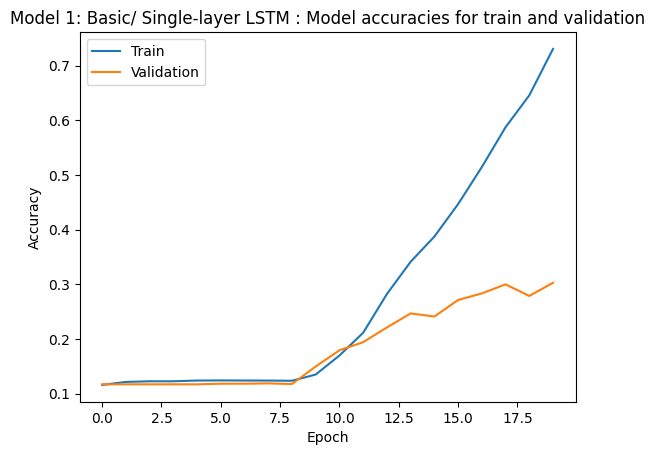

In [ ]:
print(hist.history.keys())

plt.clf()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model 1: Basic/ Single-layer LSTM : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 2: Basic RNNs

In [ ]:
model2 = Sequential()

model2.add(vectorizer)

model2.add(Embedding(max_features, embedding_dims))
model2.add(TimeDistributed(Dense(400,activation="relu")))
model2.add(SimpleRNN(embedding_dims, return_sequences=False))
model2.add(Dense(400,activation="relu"))
model2.add(Dense(400,activation="sigmoid"))
model2.add(Dense(400,activation="relu"))
model2.add(Dense(category_no,activation=tf.keras.activations.softmax))

In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model2.summary()

hist2 = model2.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          1120000   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 400)        6800      
 tributed)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                6672      
                                                                 
 dense_6 (Dense)             (None, 400)               6800      
                                                                 
 dense_7 (Dense)             (None, 400)              

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


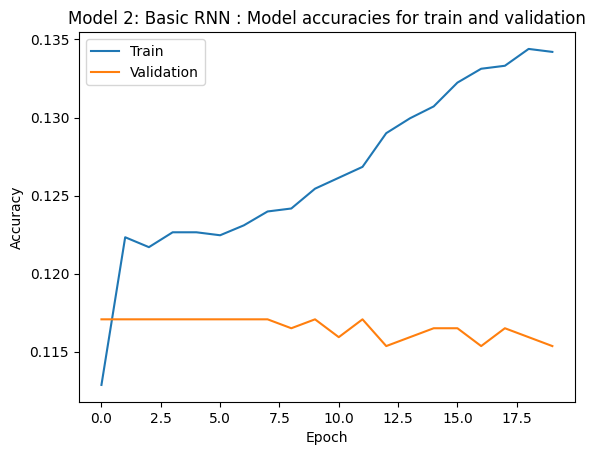

In [ ]:
print(hist2.history.keys())

plt.clf()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model 2: Basic RNN : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 3: Multi-layer LSTMs

In [ ]:
model3 = Sequential()

model3.add(vectorizer)

model3.add(Embedding(max_features, embedding_dims))
model3.add(TimeDistributed(Dense(400,activation="relu")))
model3.add(LSTM(embedding_dims, return_sequences=True))
model3.add(LSTM(embedding_dims, return_sequences=True))
model3.add(LSTM(embedding_dims, return_sequences=False))
#model3.add(Dense(400,activation="relu"))
#model3.add(Dense(400,activation="sigmoid"))
model3.add(Dense(400,activation="relu"))
model3.add(Dense(category_no,activation=tf.keras.activations.softmax))

In [ ]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model3.summary()

hist3 = model3.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 16)          1120000   
                                                                 
 time_distributed_2 (TimeDis  (None, None, 400)        6800      
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, None, 16)          26688     
                                                                 
 lstm_2 (LSTM)               (None, None, 16)          2112      
                                                                 
 lstm_3 (LSTM)               (None, 16)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


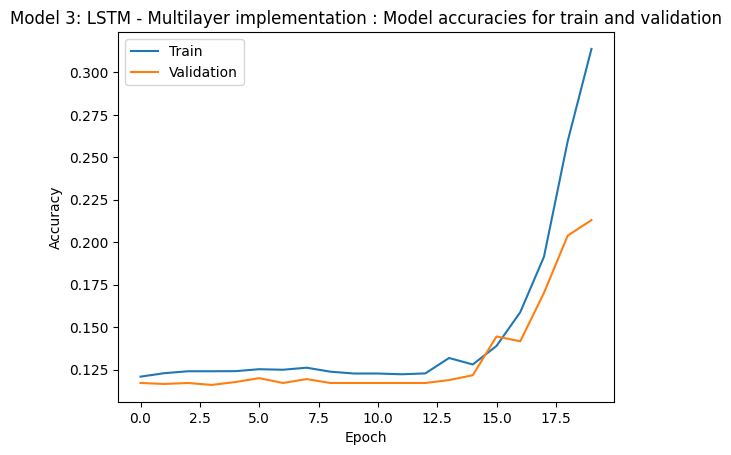

In [ ]:
print(hist3.history.keys())

plt.clf()
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Model 3: LSTM - Multilayer implementation : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 4 - Pre-trained embeddings

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], dtype=tf.string)

In [ ]:
model4 = tf.keras.Sequential()
model4.add(hub_layer)
model4.add(Dense(400,activation="relu"))
model4.add(Dense(400,activation="relu"))
model4.add(Dense(400,activation="relu"))
model4.add(Dense(400,activation="relu"))
model4.add(tf.keras.layers.Dense(20, activation='softmax'))

In [ ]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model4.summary()

hist4 = model4.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_13 (Dense)            (None, 400)               8400      
                                                                 
 dense_14 (Dense)            (None, 400)               160400    
                                                                 
 dense_15 (Dense)            (None, 400)               160400    
                                                                 
 dense_16 (Dense)            (None, 400)               160400    
                                                                 
 dense_17 (Dense)            (None, 20)                8020      
                                                                 
Total params: 897,640
Trainable params: 497,620
Non-tr

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


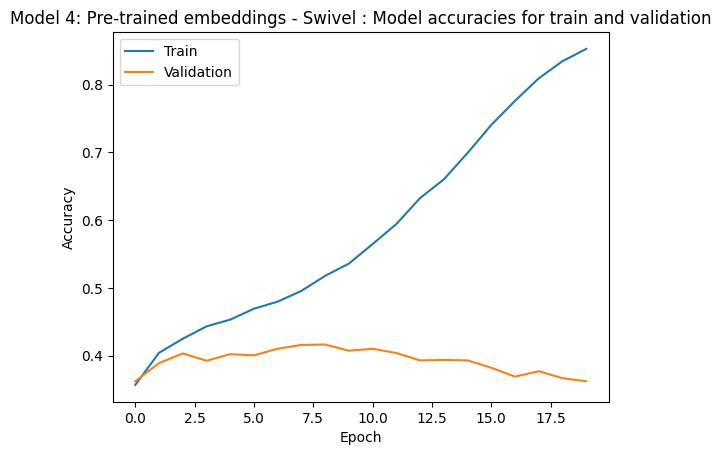

In [ ]:
print(hist4.history.keys())

plt.clf()
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('Model 4: Pre-trained embeddings - Swivel : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 5: CNN - Single CNN / Uniform kernels

In [ ]:
model5 = Sequential()

model5.add(vectorizer)

model5.add(Embedding(max_features, embedding_dims))
#model5.add(TimeDistributed(hub_layer))
model5.add(Conv1D(80, 3, padding='same', activation='relu'))
model5.add(GlobalAveragePooling1D())
model5.add(Dense(400,activation="relu"))
model5.add(Dense(400,activation="relu"))
model5.add(Dense(20,activation=tf.keras.activations.softmax))

In [ ]:
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model5.summary()

hist5 = model5.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 80)          3920      
                                                                 
 global_average_pooling1d_1   (None, 80)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 400)               32400     
                                                                 
 dense_22 (Dense)            (None, 400)              

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


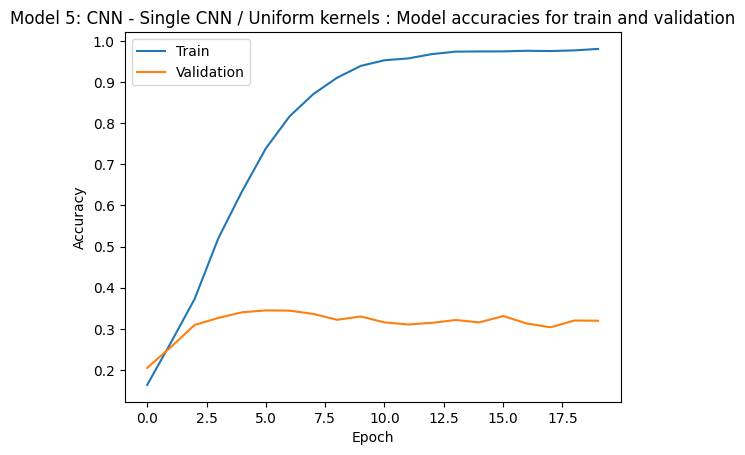

In [ ]:
print(hist5.history.keys())

plt.clf()
plt.plot(hist5.history['accuracy'])
plt.plot(hist5.history['val_accuracy'])
plt.title('Model 5: CNN - Single CNN / Uniform kernels : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 6: CNN - Heterogenous kernels

In [ ]:
model6 = Sequential()

model6.add(vectorizer)

model6.add(Embedding(max_features, embedding_dims))
model6.add(Conv1D(80, 20, padding='same', activation='relu'))
model6.add(AveragePooling1D())
model6.add(Conv1D(80, 10, padding='same', activation='relu'))
model6.add(AveragePooling1D())
model6.add(Conv1D(80, 5, padding='same', activation='relu'))
model6.add(GlobalAveragePooling1D())
model6.add(Dense(400,activation="relu"))
model6.add(Dense(400,activation="relu"))
model6.add(Dense(400,activation="relu"))
model6.add(Dense(20,activation=tf.keras.activations.softmax))

In [ ]:
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model6.summary()

hist6 = model6.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 80)          25680     
                                                                 
 average_pooling1d (AverageP  (None, None, 80)         0         
 ooling1D)                                                       
                                                                 
 conv1d_3 (Conv1D)           (None, None, 80)          64080     
                                                                 
 average_pooling1d_1 (Averag  (None, None, 80)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


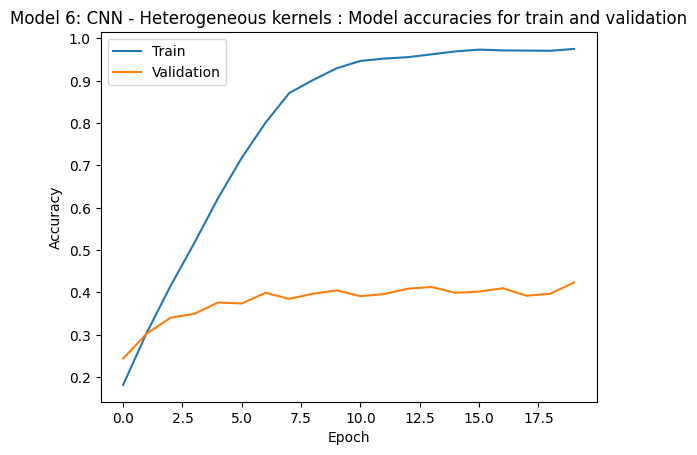

In [ ]:
print(hist6.history.keys())

plt.clf()
plt.plot(hist6.history['accuracy'])
plt.plot(hist6.history['val_accuracy'])
plt.title('Model 6: CNN - Heterogeneous kernels : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 7: CNN with LSTMs

In [ ]:
model7 = Sequential()

model7.add(vectorizer)

model7.add(Embedding(max_features, embedding_dims))
#model7.add(LSTM(embedding_dims, return_sequences=True))
model7.add(Conv1D(80, 20, padding='same', activation='relu'))
model7.add(AveragePooling1D())
model7.add(Conv1D(80, 10, padding='same', activation='relu'))
model7.add(AveragePooling1D())
model7.add(Conv1D(80, 5, padding='same', activation='relu'))
model7.add(AveragePooling1D())
model7.add(LSTM(embedding_dims, return_sequences=True))
model7.add(LSTM(embedding_dims, return_sequences=False))
model7.add(Dense(400,activation="relu"))
model7.add(Dense(400,activation="relu"))
model7.add(Dense(400,activation="relu"))
model7.add(Dense(20,activation=tf.keras.activations.softmax))

In [ ]:
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model7.summary()

hist7 = model7.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_5 (Conv1D)           (None, None, 80)          25680     
                                                                 
 average_pooling1d_2 (Averag  (None, None, 80)         0         
 ePooling1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, None, 80)          64080     
                                                                 
 average_pooling1d_3 (Averag  (None, None, 80)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


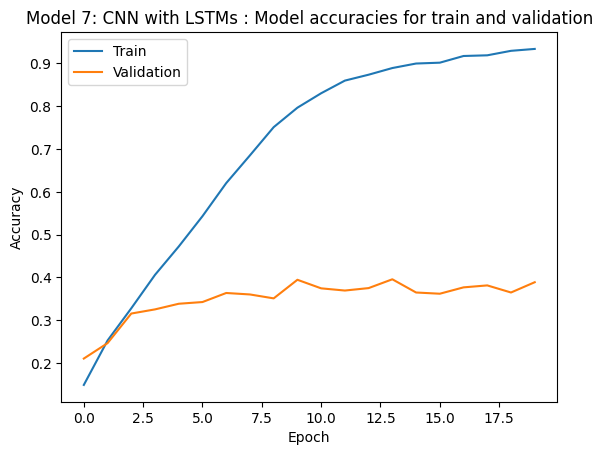

In [ ]:
print(hist7.history.keys())

plt.clf()
plt.plot(hist7.history['accuracy'])
plt.plot(hist7.history['val_accuracy'])
plt.title('Model 7: CNN with LSTMs : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 8 - Gaussian Naive Bayes (Using algorithms other than DL)

In [ ]:
def cv_preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

In [ ]:
count_vectorizer = CountVectorizer(min_df = 10, stop_words='english', preprocessor=cv_preprocess_text)
bag_of_words = count_vectorizer.fit_transform(sample['NoPunct'])
bag_of_words = pd.DataFrame(bag_of_words.toarray(), columns = count_vectorizer.get_feature_names_out())
display(bag_of_words)

,aaron,abandon,abandoned,abandoning,abbey,abbott,abbotts,abc,abcs,abe,...,zil,zimbabwe,zlatan,zoe,zombie,zone,zones,zoo,zoom,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(bag_of_words, sample['sectionName'], random_state=10, test_size=0.20)

In [ ]:
gnb_model = GaussianNB()

gnb_model.fit(X_train_nb, y_train_nb)

GaussianNB()

In [ ]:
y_pred = gnb_model.predict(X_test_nb)
acc = accuracy_score(y_test_nb, y_pred)
print(acc)

0.33624678663239077


### Model 9 - Using a combined column of webtitle and preprocessed body content

In [ ]:
sample['Combined'] = sample['webTitle'] + sample['NoPunct']
display(sample)

,lemBodyContent,sectionName,webTitle,NoPunct,Combined
55474,Cedric OBannon tried to ignore the sharp pain ...,World news,"Stabbed at a neo-Nazi rally, called a criminal...",Cedric OBannon tried to ignore the sharp pain ...,"Stabbed at a neo-Nazi rally, called a criminal..."
2340,Penalties provided Simon Mignolet with a shot ...,Football,Liverpool’s Simon Mignolet still defined by mi...,Penalties provided Simon Mignolet with a shot ...,Liverpool’s Simon Mignolet still defined by mi...
57329,Chris Grayling has been accused of running sca...,Politics,Grayling accused of 'running scared' after pul...,Chris Grayling has been accused of running sca...,Grayling accused of 'running scared' after pul...
30078,Donald Trump will unveil a proposal for a majo...,US news,Trump to unveil proposal for slashing corporat...,Donald Trump will unveil a proposal for a majo...,Trump to unveil proposal for slashing corporat...
9655,nan,Opinion,The sad story of Sully the rescue dog | First ...,nan,The sad story of Sully the rescue dog | First ...
...,...,...,...,...,...
53618,"Last month, the New Yorker ran a piece that op...",Music,Reverb remixes: the musical meme that's celebr...,"Last month, the New Yorker ran a piece that op...",Reverb remixes: the musical meme that's celebr...
21560,A father whose son was fatally struck by an ou...,Australia news,Father hugs man accused of Christmas Day crash...,A father whose son was fatally struck by an ou...,Father hugs man accused of Christmas Day crash...
89103,For the Hillsborough families whose 96 loved o...,UK news,How Duckenfield trial left Hillsborough famili...,For the Hillsborough families whose 96 loved o...,How Duckenfield trial left Hillsborough famili...
34948,Guardian writers predicted position: 6th (NB: ...,Football,Premier League 2017-18 preview No1: Arsenal | ...,Guardian writers predicted position: 6th (NB: ...,Premier League 2017-18 preview No1: Arsenal | ...


In [ ]:
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(sample['Combined'], sample['sectionName'], random_state=10, test_size=0.20)

In [ ]:
oh = OneHotEncoder()
y_train_le_C = pd.get_dummies(y_train_C)
y_test_le_C = pd.get_dummies(y_test_C)
#y_val_le = pd.get_dummies(y_val)

display(y_train_le_C)

,Art and design,Australia news,Books,Business,Environment,Film,Football,Life and style,Media,Music,Opinion,Politics,Society,Sport,Stage,Technology,Television & radio,UK news,US news,World news
137710,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
136003,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
63694,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
110986,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
64810,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56392,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
62086,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
50185,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
112012,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], dtype=tf.string)

In [ ]:
model9 = tf.keras.Sequential()
model9.add(hub_layer)
model9.add(Dense(400,activation="relu"))
model9.add(Dense(400,activation="relu"))
model9.add(Dense(400,activation="relu"))
model9.add(Dense(400,activation="relu"))
model9.add(tf.keras.layers.Dense(20, activation='softmax'))

In [ ]:
model9.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

hist9 = model9.fit(X_train_C, y_train_le_C,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Epoch 1/20
438/438 [==============================] - 3s 5ms/step - loss: 1.9278 - accuracy: 0.3748 - val_loss: 1.8555 - val_accuracy: 0.3811
Epoch 2/20
438/438 [==============================] - 2s 5ms/step - loss: 1.7431 - accuracy: 0.4299 - val_loss: 1.7374 - val_accuracy: 0.4377
Epoch 3/20
438/438 [==============================] - 2s 5ms/step - loss: 1.6645 - accuracy: 0.4575 - val_loss: 1.7672 - val_accuracy: 0.4216
Epoch 4/20
438/438 [==============================] - 2s 4ms/step - loss: 1.6129 - accuracy: 0.4712 - val_loss: 1.7324 - val_accuracy: 0.4357
Epoch 5/20
438/438 [==============================] - 2s 4ms/step - loss: 1.5586 - accuracy: 0.4857 - val_loss: 1.7251 - val_accuracy: 0.4299
Epoch 6/20
438/438 [==============================] - 2s 4ms/step - loss: 1.5023 - accuracy: 0.4952 - val_loss: 1.7493 - val_accuracy: 0.4402
Epoch 7/20
438/438 [==============================] - 2s 4ms/step - loss: 1.4477 - accuracy: 0.5090 - val_loss: 1.7527 - val_accuracy: 0.4377
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


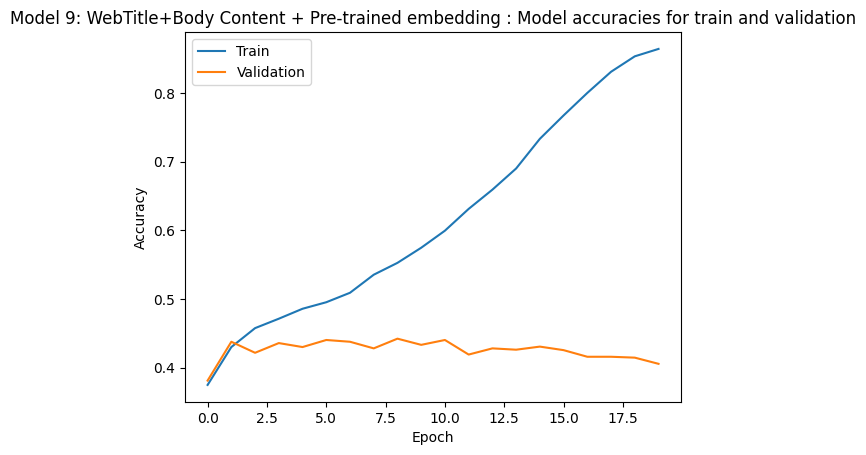

In [ ]:
print(hist9.history.keys())

plt.clf()
plt.plot(hist9.history['accuracy'])
plt.plot(hist9.history['val_accuracy'])
plt.title('Model 9: WebTitle+Body Content + Pre-trained embedding : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 10 - CNN - Uniform kernels

In [ ]:
model10 = Sequential()

model10.add(vectorizer)

model10.add(Embedding(max_features, embedding_dims))
#model7.add(LSTM(embedding_dims, return_sequences=True))
model10.add(Conv1D(80, 10, padding='same', activation='relu'))
model10.add(AveragePooling1D())
model10.add(Conv1D(80, 10, padding='same', activation='relu'))
model10.add(AveragePooling1D())
model10.add(Conv1D(80, 10, padding='same', activation='relu'))
model10.add(AveragePooling1D())
model10.add(LSTM(embedding_dims, return_sequences=True))
model10.add(LSTM(embedding_dims, return_sequences=False))
model10.add(Dense(400,activation="relu"))
model10.add(Dense(400,activation="relu"))
model10.add(Dense(400,activation="relu"))
model10.add(Dense(20,activation=tf.keras.activations.softmax))

In [ ]:
model10.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model10.summary()

hist10 = model10.fit(X_train, y_train_le,
          batch_size=32,
          epochs=20,
         validation_split=0.10)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_7 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_8 (Conv1D)           (None, None, 80)          12880     
                                                                 
 average_pooling1d_5 (Averag  (None, None, 80)         0         
 ePooling1D)                                                     
                                                                 
 conv1d_9 (Conv1D)           (None, None, 80)          64080     
                                                                 
 average_pooling1d_6 (Averag  (None, None, 80)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


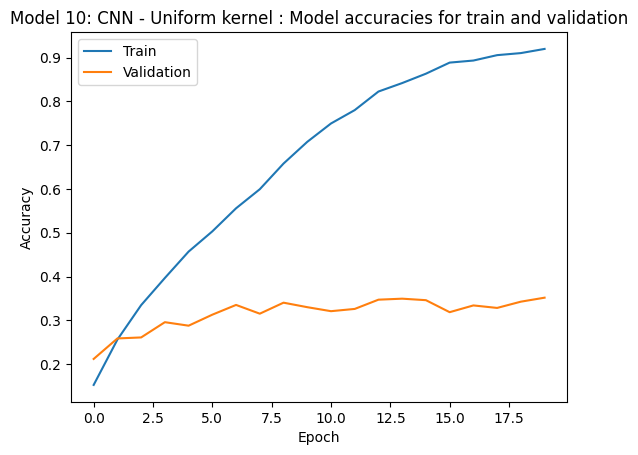

In [ ]:
print(hist10.history.keys())

plt.clf()
plt.plot(hist10.history['accuracy'])
plt.plot(hist10.history['val_accuracy'])
plt.title('Model 10: CNN - Uniform kernel : Model accuracies for train and validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluating all the models

In [ ]:
p1_model_accs = []

In [ ]:
acc1 = model.evaluate(X_test, y_test_le, batch_size=32)
print("Model 1: Test loss/ Test acc")
print(acc1)
p1_model_accs.append(acc1[1])

61/61 [==============================] - 2s 26ms/step - loss: 3.8226 - accuracy: 0.3090
Model 1: Test loss/ Test acc
[3.822634696960449, 0.30899742245674133]


In [ ]:
acc2 = model2.evaluate(X_test, y_test_le, batch_size=32)
print("Model 2: Test loss/ Test acc")
print(acc2)
p1_model_accs.append(acc2[1])

61/61 [==============================] - 1s 13ms/step - loss: 2.8763 - accuracy: 0.1296
Model 2: Test loss/ Test acc
[2.876277208328247, 0.12956298887729645]


In [ ]:
acc3 = model3.evaluate(X_test, y_test_le, batch_size=32)
print("Model 3: Test loss/ Test acc")
print(acc3)
p1_model_accs.append(acc3[1])

61/61 [==============================] - 3s 50ms/step - loss: 2.6016 - accuracy: 0.2149
Model 3: Test loss/ Test acc
[2.6016042232513428, 0.21491003036499023]


In [ ]:
acc4 = model4.evaluate(X_test, y_test_le, batch_size=32)
print("Model 4: Test loss/ Test acc")
print(acc4)
p1_model_accs.append(acc4[1])

61/61 [==============================] - 0s 2ms/step - loss: 3.8287 - accuracy: 0.3815
Model 4: Test loss/ Test acc
[3.8287274837493896, 0.3814910054206848]


In [ ]:
acc5 = model5.evaluate(X_test, y_test_le, batch_size=32)
print("Model 5: Test loss/ Test acc")
print(acc5)
p1_model_accs.append(acc5[1])

61/61 [==============================] - 0s 3ms/step - loss: 9.8564 - accuracy: 0.3429
Model 5: Test loss/ Test acc
[9.85643482208252, 0.3429305851459503]


In [ ]:
acc6 = model6.evaluate(X_test, y_test_le, batch_size=32)
print("Model 6: Test loss/ Test acc")
print(acc6)
p1_model_accs.append(acc6[1])

61/61 [==============================] - 1s 8ms/step - loss: 4.9090 - accuracy: 0.4139
Model 6: Test loss/ Test acc
[4.9089813232421875, 0.41388174891471863]


In [ ]:
acc7 = model7.evaluate(X_test, y_test_le, batch_size=32)
print("Model 7: Test loss/ Test acc")
print(acc7)
p1_model_accs.append(acc7[1])

61/61 [==============================] - 1s 11ms/step - loss: 4.3046 - accuracy: 0.3933
Model 7: Test loss/ Test acc
[4.304594039916992, 0.39331620931625366]


In [ ]:
y_pred = gnb_model.predict(X_test_nb)
acc = accuracy_score(y_test_nb, y_pred)
print(acc)
p1_model_accs.append(acc)

0.33624678663239077


In [ ]:
acc9 = model9.evaluate(X_test_C, y_test_le_C, batch_size=32)
print("Model 7: Test loss/ Test acc")
print(acc9)
p1_model_accs.append(acc9[1])

122/122 [==============================] - 0s 2ms/step - loss: 3.4889 - accuracy: 0.4100
Model 7: Test loss/ Test acc
[3.4888505935668945, 0.4100257158279419]


In [ ]:
acc10 = model10.evaluate(X_test, y_test_le, batch_size=32)
print("Model 10: Test loss/ Test acc")
print(acc10)
p1_model_accs.append(acc10[1])

61/61 [==============================] - 1s 11ms/step - loss: 3.9818 - accuracy: 0.3702
Model 10: Test loss/ Test acc
[3.9817535877227783, 0.3701799511909485]


In [ ]:
print(p1_model_accs)

[0.30899742245674133, 0.12956298887729645, 0.21491003036499023, 0.3814910054206848, 0.3429305851459503, 0.41388174891471863, 0.39331620931625366, 0.33624678663239077, 0.4100257158279419, 0.3701799511909485]


### Plotting the test accuracies as a graph

In [ ]:
model_nos = [1,2,3,4,5,6,7,8,9, 10]

# Plot as a bar-graph
fig = px.bar(
    sample_portion, x=model_nos, y=p1_model_accs,
    title = "Fig: Evaluation accuracies of Part 1 models",
    labels={'x' : 'Model No.', 'y': 'Test Accuracy'}
)

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

fig.show()

### Making a excel with only the test data for the demo notebook

In [ ]:
test_data_df = pd.DataFrame({
    'bodyContent' : X_test,
    'sectionName' : y_test
})
display(test_data_df)

,bodyContent,sectionName
144813,The Guardian is looking into thefts of cryptoc...,Technology
94897,Most days you cant walk through San Franciscos...,World news
1132,One of the many fascinating aspects of John Se...,Music
106414,Congressional Democrats have launched contempt...,US news
15691,.,Sport
...,...,...
19991,"It was, said Nick Clegg, something youd expect...",UK news
38321,Maurice the French cockerel fancies himself as...,World news
101198,Expectations continue to grow over the prospec...,Football
101267,"Black, Asian and minority ethnic people in Eng...",World news


In [ ]:
#test_data_df.to_csv("guardian_testrecords.csv")

### Saving the model

For future use in transformers and demo notebooks, we will be saving model 6 and 7. This is done after considering the performance on train/validation and test data. Also considered that moving forward for transformers, using custom networks with LSTMs and a few CNN layers would be insightful.

In [ ]:
model5.save('saved_model/model6save')

INFO:tensorflow:Assets written to: saved_model/model6save\assets


INFO:tensorflow:Assets written to: saved_model/model6save\assets


In [ ]:
trial_load = tf.keras.models.load_model('saved_model/model6save')
trial_load.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, None, 16)          1120000   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 80)          3920      
                                                                 
 global_average_pooling1d_1   (None, 80)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 400)               32400     
                                                                 
 dense_22 (Dense)            (None, 400)              

In [ ]:
print(trial_load.layers[6])

In [ ]:
model7.save('saved_model/model7save')

INFO:tensorflow:Assets written to: saved_model/model7save\assets


INFO:tensorflow:Assets written to: saved_model/model7save\assets


In [ ]:
model4.save('saved_model/model4save')